This notebook is for development! Use it to try out new strategies :) 

<div class="alert alert-block alert-info">
<b>Imports:</b> Common imports for NumPy, MatplotLib, Pandas, and OS </div>

In [1]:
## Import for data generation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle

<div class="alert alert-block alert-info">
<b>ML Imports:</b> Imports to execute RNN model for sequential data </div>

In [2]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
from pyspark import SparkContext
from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

<div class="alert alert-block alert-warning">
<b>nn_train_test() function:</b> 
    
This function creates the train and test sets a little differently. Instead of using pca to reduce dimensionality, it keeps all the data in anticipation of the Neural Net Framework to deal with filtering through it. The d variable allows you to discretize the grid down further as well.
    
    path --> path to the repository with all your .npy file
    n_future --> number of future days of fire you want to predict (will be 1 for us)
    n_comp --> Doesn't do anything right now
    n_past --> number of past days you want to consider (we can experiment with this)
    d --> The size of the discretized fires you want (i.e. d= 32, returns subset of sequences for 32x32 grids)
    
Outputs:
    
    input_dim is set to a 1-D array of 256 ^ 2 for now! 
    x_train --> x_train in format (batch_size, timesteps, input_dim)
    y_train --> training data in format (batch_size, input_dim)
    pca_array -->  Nothing
    
</div>

In [3]:
def nn_train_test(path, n_past, n_comp, n_future = 1, d = 256):
    x_train_list = []
    y_train_list = []
    count = 0
    pca_array = []
    for file in os.listdir(r"{path}".format(path = path)):
        if os.path.getsize("{path}\\{file}".format(path = path, file = file)) < 10000000:
            continue
        with open("{path}\\{file}".format(path = path, file = file), 'rb') as f:
            data = pickle.load(f)
        training_fire = data['multiDay']
        elevation_data = data['Elevation Data'][:-1,:-1]
        elev_shape = np.array(elevation_data.shape)
        elevation_fire = np.zeros((256, 256))
        shape = np.array(training_fire.shape) 
        fire = np.where(training_fire[1] == 1)
        x_center, y_center = int(np.median(fire[0])), int(np.median(fire[1]))
        if shape[0] < n_past + n_future:
            continue
        standard_fire = np.zeros((len(training_fire), 256, 256))    
        if shape[1] > 255 or shape[2] > 255:


            # could not broadcast input array from shape (39,350,325) into shape (39,512,416)
            xLow = x_center - 128 
            xHi = shape[1] - x_center
            yLow = y_center - 128
            yHi = shape[2] - y_center
            print(xLow, xHi, yLow, yHi)
            if shape[1] > 255:
                if xLow < 0:
                    xHi = x_center + 128 - xLow
                    xLow = 0
                elif xHi < 128:
                    xLow = x_center - 256 + xHi
                    xHi = shape[1]
                else:
                    xLow = x_center - 128
                    xHi = x_center + 128
            else:
                xLow = 0
                xHi = shape[1]

            if shape[2] > 255:
                if yLow < 0:
                    yHi = y_center + 128 - yLow
                    yLow = 0
                elif yHi < 128:
                    yLow = y_center - 256 + yHi
                    yHi = shape[2]
                else:
                    yLow = y_center - 128
                    yHi = y_center + 128
            else:
                yLow = 0
                yHi = shape[2]
            print(xLow, xHi, yLow, yHi)
            standard_fire[:shape[0], :min(256, shape[1]), :min(256, shape[2])] = training_fire[:, xLow: xHi, yLow: yHi]   
            elevation_fire[:min(256, elev_shape[0]), :min(256, elev_shape[1])] = elevation_data[xLow: xHi, yLow: yHi]
        else: 
            standard_fire[:shape[0], :shape[1], :shape[2]] = training_fire
            elevation_fire[:min(256, elev_shape[0]), :min(256, elev_shape[1])] = elevation_data

        pca_fire = standard_fire
        pca_elev = elevation_fire.reshape((1, 256, 256))
        for i in range(0 , len(training_fire) - n_future - n_past + 1):
            shape = pca_fire[i : i + n_past].shape
            a = np.zeros((shape[0] + 1, shape[1], shape[2]))
            a[:3] = pca_fire[i : i + n_past]
            a[3:] = pca_elev 
            for j in np.arange(0, 255, d):
                for k in np.arange(0, 255, d):
                    x_train_list.append(a[:, j:j+d, k:k+d])
                    y_train_list.append(pca_fire[i + n_past: i + n_past + n_future, j:j+d, k:k+d])
    
    x_train = np.array(x_train_list)
    y_train = np.array(y_train_list)  
    
    #x_train = np.reshape(x_train, (x_train.shape[0],  x_train.shape[2], x_train.shape[1]))
    #y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[2]))    
    print(x_train.shape, y_train.shape, len(pca_array))
    return x_train, y_train, pca_array

<div class="alert alert-block alert-warning">
<b>RNN Inputs:</b> 
We are declaring below that the number of future days we want to predict is 1, and we can vary the number of past days
    we want to predict (I have the default as 3 for now)

</div>

In [4]:
n_future = 1
n_comp = 10
n_past = 3
discretization_amount = d = 64 # 256 means we keep the whole fire grid

<div class="alert alert-block alert-warning">
<b>Input Data for Training:</b> 
    Below, we get the input data from December 2018! 
</div>

In [62]:
%%capture 
# We are suppressing print statements and warning messages w/ above line
path = "C:\\Users\\nico\\Desktop\\Stanford\\OneDrive - Stanford\\Courses\\CS229\\finalproject\\data\\United_States_Fires\\United_States_2018_Fires\\dec\\storage"  
x_train, y_train, pca_array  = nn_train_test(path, n_past = n_past, n_comp = n_comp, n_future = n_future, d = d)

<div class="alert alert-block alert-warning">
<b>Check:</b> 
    Check the shape of your x_train and y_train data
</div>

In [8]:
x_train.shape, y_train.shape

((6528, 4, 64, 64), (6528, 1, 64, 64))

<div class="alert alert-block alert-success">
    This follows the model in https://towardsdatascience.com/wildfire-spreading-modeling-in-alberta-canada-a-trial-using-a-neural-network-with-convlstm-cells-81c1a9f7d410. Their GitHub is at the bottom of the page 
    
<b>Train your RNN:</b> Train your RNN using the training data.
    
    You might notice a lot of arbitrary values here (these are things we will want to change and test)
    - Dropout: High dropout leads to more generalization. Low dropout takes advantage of more data but overfits more easily
    - # of hidden layers: Right now, there are 2 hidden layers (+ 1 at the end). We can change this
    - # units at hidden layers: Right now, units decrease by 1 at each hidden layer. This is arbitrary and can be changed
    - optimizer --> 'adam' works but I don't know what it does
    - epochs --> We can raise this above 1 but I don't notice that changing much when I have done so
    - batch_size --> Higher batch size leads to more generalization
</div>

Reshape your data as needed for the ConvLSTM

In [63]:
x_train, y_train = x_train.reshape((int(408 * 256**2/d**2), d, d, 4)), y_train.reshape((int(408 * 256**2/d**2), d*d))

In [10]:
x_train.shape, y_train.shape

((6528, 64, 64, 4), (6528, 4096))

In [88]:
y_train = np.array([np.sum(y) for y in y_train])

In [64]:
x_train[:, :, :, 3][x_train[:, :, :, 3] == -9999] = 0
for i in range(len(x_train)):
    if x_train[i, :, :, 3].sum() > 0:
        x_train[i,:,:,3] = x_train[i,:,:,3] / x_train[i,:,:,3].sum()
        

In [130]:
# No need to run this if you are loading a model
regressor = Sequential()

dropout = 0.1

#regressor.add(tf.keras.layers.Masking(mask_value=-9999,input_shape= x_train[0].shape)) 

regressor.add(tf.keras.layers.Conv2D(filters = d, kernel_size = (3,3), padding = "same", activation = "tanh", input_shape = x_train[0].shape))


regressor.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

'''
regressor.add(tf.keras.layers.Conv2D(filters = 2*d, kernel_size = (3,3), padding = "same", activation = "relu"))

regressor.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
'''

regressor.add(tf.keras.layers.Flatten())

regressor.add(tf.keras.layers.Dense(units = 4*d, activation = 'relu'))

regressor.add(tf.keras.layers.Dropout(0.0))

regressor.add(tf.keras.layers.Dense(units = 8*d, activation = 'relu'))

regressor.add(tf.keras.layers.Dropout(0.0))
'''

regressor.add(tf.keras.layers.Dense(units = 16*d, activation = 'relu'))

regressor.add(tf.keras.layers.Dropout(0.0))

regressor.add(tf.keras.layers.Dense(units = 32*d, activation = 'relu'))

regressor.add(tf.keras.layers.Dropout(0.0))
'''

regressor.add(tf.keras.layers.Dense(units = 1, activation = 'relu'))

'''
regressor.add(tf.keras.layers.Bidirectional(LSTM(units=n_past, return_sequences=True, input_shape = x_train[0].shape)))
regressor.add(Dropout(dropout))

regressor.add(LSTM(units = n_past-1, return_sequences = True))
regressor.add(Dropout(dropout))

regressor.add(LSTM(units = n_past-2, return_sequences = False))
regressor.add(Dropout(dropout))

regressor.add(LSTM(units = n_past, return_sequences = True))
regressor.add(Dropout(dropout))


regressor.add(Dense(units = n_future, activation = 'linear'))
'''

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['acc'])

regressor.fit(x_train, y_train, epochs = 10, batch_size = 10)

Epoch 1/10
653/653 [==============================] - 42s 65ms/step - loss: 97230.7734 - acc: 0.2413
Epoch 2/10
653/653 [==============================] - 42s 65ms/step - loss: 93375.2266 - acc: 0.2678
Epoch 3/10
653/653 [==============================] - 43s 66ms/step - loss: 91697.4219 - acc: 0.2540
Epoch 4/10
653/653 [==============================] - 42s 64ms/step - loss: 87190.7578 - acc: 0.1999
Epoch 5/10
653/653 [==============================] - 42s 65ms/step - loss: 86751.2656 - acc: 0.2377
Epoch 6/10
653/653 [==============================] - 43s 65ms/step - loss: 83168.3594 - acc: 0.1578
Epoch 7/10
653/653 [==============================] - 42s 65ms/step - loss: 82603.2031 - acc: 0.2736
Epoch 8/10
653/653 [==============================] - 42s 64ms/step - loss: 81061.6094 - acc: 0.2509 3s - loss: 8001 - ETA: 2s
Epoch 9/10
653/653 [==============================] - 40s 61ms/step - loss: 78094.7969 - acc: 0.1880
Epoch 10/10
653/653 [==============================] - 40s 61ms/s

<div class="alert alert-block alert-success">
This follows the general layout of https://keras.io/examples/vision/conv_lstm/. I haven't had much success with it
    
<b>Train your RNN:</b> Train your RNN using the training data.
    
    You might notice a lot of arbitrary values here (these are things we will want to change and test)
    - Dropout: High dropout leads to more generalization. Low dropout takes advantage of more data but overfits more easily
    - # of hidden layers: Right now, there are 2 hidden layers (+ 1 at the end). We can change this
    - # units at hidden layers: Right now, units decrease by 1 at each hidden layer. This is arbitrary and can be changed
    - optimizer --> 'adam' works but I don't know what it does
    - epochs --> We can raise this above 1 but I don't notice that changing much when I have done so
    - batch_size --> Higher batch size leads to more generalization
</div>

In [235]:
x_train, y_train = x_train.reshape((int(408 * 256**2/d**2), 4, d, d, 1)), y_train.reshape((int(408 * 256**2/d**2), d, d))

In [ ]:
# No need to run this if you are loading a model
regressor = Sequential()

dropout = 0.1
# Construct the input layer with no definite frame size.
inp = tf.keras.layers.Input(shape=(None, *x_train.shape[2:]))
#regressor.add(tf.keras.layers.Masking(mask_value=-9999,input_shape= x_train[0].shape)) 
x = tf.keras.layers.ConvLSTM2D(filters = 64, kernel_size = (5,5), padding="same", return_sequences = True, activation = "relu")(inp)

x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = tf.keras.layers.ConvLSTM2D(
    filters=1,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)

'''
x = tf.keras.layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)
'''

model = tf.keras.models.Model(inp, x)
model.compile(
    loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(),
)

model.fit(
    x_train,
    y_train,
    batch_size=1,
    epochs=1
)



<div class="alert alert-block alert-warning">
<b>Load pre-trained model:</b> 
    If you want to load a model instead, use this
</div>

In [10]:
from keras.models import load_model
model_name = '' ## CHANGE THIS (e.g. 'my_model') ##
regressor = load_model(model_name)

<div class="alert alert-block alert-warning">
<b>Save pre-trained model:</b> 
    If you want to save a model instead, use this
</div>

In [144]:
model_name = '1d-output'## CHANGE THIS (e.g. 'my_model') ##
regressor.save(model_name)

INFO:tensorflow:Assets written to: 1d-output\assets


<div class="alert alert-block alert-warning">
<b>Input Data for Testing:</b> 
    Below, we get the input data from March 2018! 
</div>

In [131]:
%%capture
path = path = "C:\\Users\\nico\\Desktop\\Stanford\\OneDrive - Stanford\\Courses\\CS229\\finalproject\\data\\United_States_Fires\\United_States_2018_Fires\\nov\\storage"
x_test, y_test, pca_array  = nn_train_test(path, n_past = 3, n_comp = n_comp, n_future =1, d = d)

<div class="alert alert-block alert-warning">
<b>Check:</b> I've noticed the first dimensions of these sometimes these don't match. They should.
</div>

In [133]:
x_test, y_test = x_test.reshape((x_test.shape[0], d, d, 4)), y_test.reshape((int(y_test.shape[0]), d, d))

In [135]:
y_test = np.array([np.sum(y) for y in y_test])

In [137]:
y_test.shape

(2192,)

In [84]:
x_test[:, :, :, 3][x_test[:, :, :, 3] == -9999] = 0
for i in range(len(x_test)):
    if x_test[i,:,:,3].sum() > 0:
        x_test[i,:,:,3] = x_test[i,:,:,3] / x_test[i,:,:,3].sum()

<div class="alert alert-block alert-warning">
<b> Predict Step:</b> This makes your predictions using your model and reshapes them into a list of 2D arrays
</div>

In [138]:
from sklearn.preprocessing import MinMaxScaler
predict_test = regressor.predict(x_test)
p = predict_test
shape = predict_test.shape
#p = p.reshape((p.shape[0], d, d))

In [139]:
k = 163
p[k], y_test[k]

(array([0.], dtype=float32), 0.0)

In [141]:
predict_train = regressor.predict(x_train)

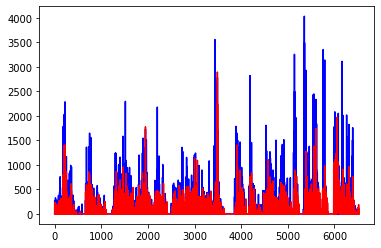

In [145]:
plt.plot(y_train, 'blue')
plt.plot(predict_train, 'red')

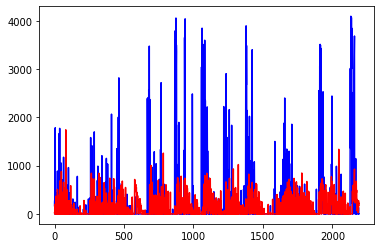

In [140]:
plt.plot(y_test, 'blue')
plt.plot(p, 'red')

In [100]:
y_test = np.array([np.sum(y) for y in y_test])

In [73]:
x_test[599,:,:,3]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00083548, 0.00067931, 0.00073137, ..., 0.00108274, 0.00119205,
        0.00125712],
       [0.00082507, 0.00065589, 0.00071055, ..., 0.00115041, 0.00124411,
        0.00124411],
       [0.00080945, 0.00064548, 0.00078082, ..., 0.00122589, 0.00117904,
        0.00115041]])

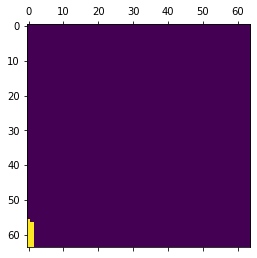

In [74]:
plt.matshow(y_test[666])

In [86]:
np.sum(p)

0.0

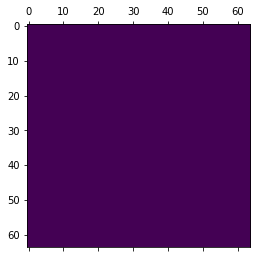

In [76]:
plt.matshow(p[60])